# Make Bipedal Robot Walk

This is the midterm assignment for the Move37 course. 

The Goal is to make a 2D robot learn how to walk. That's a simple task, since we're basically given the code in the lectures.

I'm making two substantial changes to the code:
- adding a tanh activation (as this will naturally squeeze actions into the desired [-1, 1] range.
- adding learning rate annealing.

I also change the code, making the training part (at least to my eye) more modular and extendable.

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import gym

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython import display

plt.style.use('seaborn')

np.random.seed(1)

In [3]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    From http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display.display(display_animation(anim, default_mode='loop'))

In [4]:
ENV = gym.make('BipedalWalker-v2')
SIM_NUM = 750  # Number of epochs to train our agent
LR = 2e-2
ENV.env.seed(1)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


[1]

In [5]:
print(ENV.observation_space, ENV.action_space)
print(min(ENV.observation_space.low), max(ENV.observation_space.high))
print(ENV.action_space.low, ENV.action_space.high)

Box(24,) Box(4,)
-inf inf
[-1. -1. -1. -1.] [1. 1. 1. 1.]


In [6]:
class Base_Policy():
    
    '''Base class. Defines policy by a weight matrix W.'''
    
    def __init__(self, env = ENV, clip_reward = True):
        self.env = env
        self.nS = env.observation_space.shape[0]  # Num of states
        self.nA = env.action_space.shape[0]  # Num of actions
        self.W = np.zeros((self.nA, self.nS))  # Action dim is 0 to avoid transposes later
        self.n = 0  # count of how many times we have played
        self.clip_reward = clip_reward  # if true, we squeeze rewards into [-1, 1]
    
    def pi(self, state, W = None):
        '''Out policy. Returns action from state.
        
        Note: we can optionally supply a weight matrix W, if we do so, we play
        policy according to this supplied matrix.'''
        
        if W is None: W = self.W 
        return np.tanh(W @ state)
    
    def playPol(self, W = None, save_frames = False):
        '''Plays a game from start to finish. 
        
        Note: we can optionally supply a weight matrix W, if we do so, we play
        policy according to this supplied matrix.'''
        
        self.s = self.env.reset()
        frames = []; reward = 0
        for i in range(2000):
            if save_frames: frames.append(self.env.render(mode = 'rgb_array'))
            self.call_before_action()
            action = self.pi(self.s, W)
            self.s, self.r, self.done, _ = self.env.step(action)
            if self.clip_reward:
                self.r = max(min(self.r, 1), -1)
            reward += self.r
            self.n += 1
            if self.done: break
        if save_frames: self.env.close()
        return (reward, frames)
    
    def sample_deltas(self, num):
        '''Samples random matrices of shape W.shape for random search.'''
        return [np.random.randn(*self.W.shape) for _ in range(num)]
    
    def call_before_action(self):
        '''Optional method that gets executed every round before policy.'''
        pass

In [7]:
base_pol = Base_Policy()

In [8]:
def illustrate(pol, skip_frames = 20):
    '''Plays one round according to pol, visualizes results.
    Note: I skip frames so that notebook takes less memory, and movie is faster.'''
    reward, frames = pol.playPol(save_frames = True)
    print(f'Total reward: {reward}')
    display_frames_as_gif(frames[:len(frames):skip_frames])

In [9]:
# illustrate(base_pol) # Comment out, so notebook takes up less space

## Normalize State

The previous agent didn't normalize its state (the inputs for an action). We add normalization here.

In [10]:
class norm_Policy(Base_Policy):
    '''Same policy as Base, except that we normalize inputs to mean 0, and std 1.'''
    
    def __init__(self, clip_reward = True):
        super().__init__(clip_reward = clip_reward)
        self.inp_mean, self.inp_var = np.zeros(self.nS), np.ones(self.nS)
        self.mean_diff = np.zeros(self.nS)
        
    def call_before_action(self):
        '''This function is called before calling our policy to get the next action.'''
        self.update_stats()  # Updates means and std with current state value
        if self.n >= 2: 
            self.normalize_state()  # Normalizes inputs

    def update_stats(self):
        '''Update our mean and std calculations'''
        last_mean = self.inp_mean.copy()
        self.inp_mean += (self.s - self.inp_mean) / max(self.n, 1)
        self.mean_diff += (self.s - last_mean) * (self.s - self.inp_mean)
        self.inp_var = np.clip((self.mean_diff / max(self.n, 1)), a_min = 1e-2, a_max = None)
        
    def normalize_state(self):
        '''Normalize state that gets fed into our policy.'''
        self.s = (self.s - self.inp_mean) / np.sqrt(self.inp_var)

In [11]:
norm_pol = norm_Policy()  

## Random Search Over Parameters

Our agent is ready. Now we implement a class that takes care of training and updating weights.

In [12]:
def run_avg(x, beta = 0.9, bias_correct = True):
    '''Calculates exponential running average of x.'''
    r = 0; res = np.zeros(len(x))
    for i in range(len(x)):
        r = beta*r + (1-beta)*x[i]
        res[i] = r
    if bias_correct:
        res = res / (1 - beta **(np.arange(len(x))+1))
    return res

In [13]:
class Learner():
    '''This class trains our policy.'''
    
    def __init__(self, pol):
        self.pol = pol  # The policy to optimize
        self.num_deltas = 16  # The number of parameter peturbations per epoch
        self.noise = 0.03  # Multiplier for the peturbations
        self.num_best_deltas = 16  # Number of peturbations to keep for the updates
        self.rewards = []  # List of rewards
        self.epoch = 0  # The number of epochs for training.
        
    def train(self, epochs, lr): 
        '''Trains our policy for epochs rounds with learning rate lr.'''
        for epoch in tqdm(range(epochs), position = 0):
            if (epoch) % 10 == 0:  # Update plot every 10 rounds
                self.plot_reward()
                display.clear_output(wait=True)
                display.display(plt.gcf())
            self.train_episode(lr)
        plt.close('all')
    
    def train_episode(self, lr):
        '''Trains our policy for a single epoch.'''
        
        self.epoch += 1
        
        deltas = self.pol.sample_deltas(self.num_deltas)  # Parameter peturbations
        
        # Calculate rewards from adding and subtracting the deltas
        pos_r = np.array([self.pol.playPol(self.pol.W + self.noise*deltas[i])[0] 
                          for i in range(self.num_deltas)])
        neg_r = np.array([self.pol.playPol(self.pol.W - self.noise*deltas[i])[0] 
                          for i in range(self.num_deltas)])
        
        sigma = (pos_r + neg_r).std()
        
        # Only keep the top performing peturbations
        sort_idx = np.argsort(-np.maximum(pos_r, neg_r))[:self.num_best_deltas]
        
        # Calculate the 'gradient', by summing up the weighted (top) peturbations
        grad = np.array([deltas[i]*(pos_r[i]-neg_r[i]) for i in sort_idx]).sum(axis = 0)
        grad = grad / (sigma * self.num_best_deltas)
        
        # Update our policy weights based on our gradient
        step = self.getStep(grad, lr)        
        self.pol.W += step
        
        # Calculate and return the un-peturbed reward
        rew, _ = self.pol.playPol()
        self.rewards.append(rew)
        return rew
        
    def getStep(self, grad, lr):
        '''Create update step for parameters based on gradients and learning rate.'''
        return grad * lr
        
    def plot_reward(self):
        '''Plot rewards.'''
        f, ax = plt.subplots(figsize=(5, 5))
        ax = plt.plot(run_avg(self.rewards), '-')  

In [14]:
learn = Learner(norm_pol)

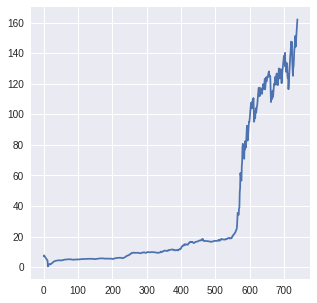

100%|██████████| 750/750 [39:21<00:00,  3.15s/it]


In [15]:
learn.train(SIM_NUM, LR)

Total reward: 61.87819590069972



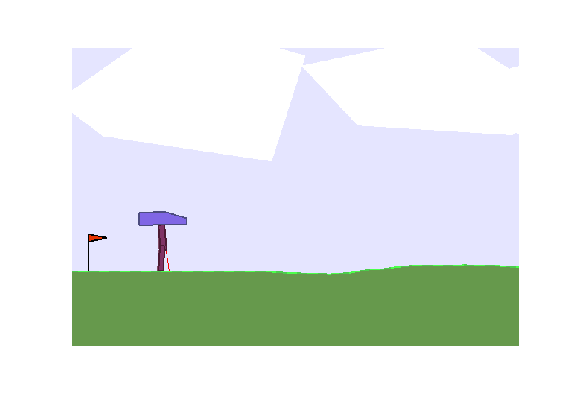
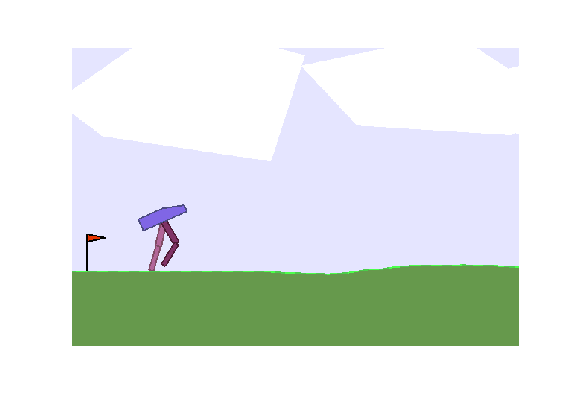
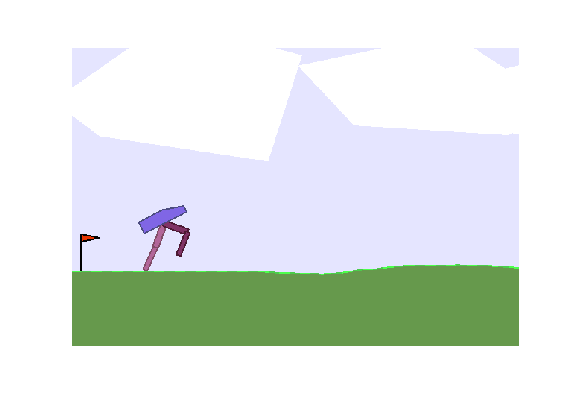
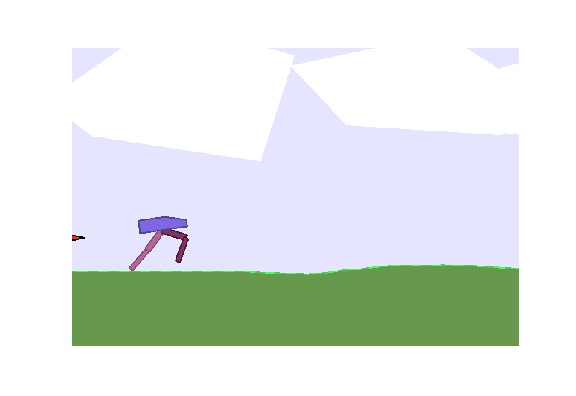
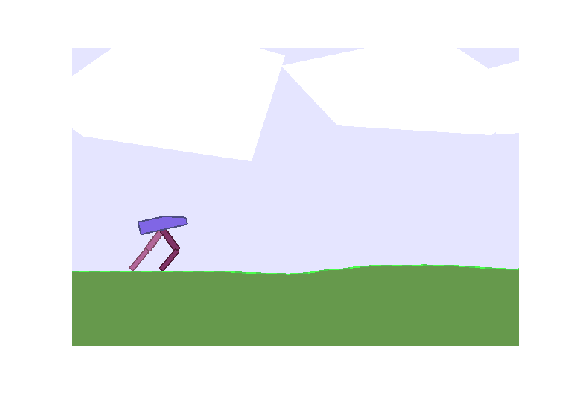
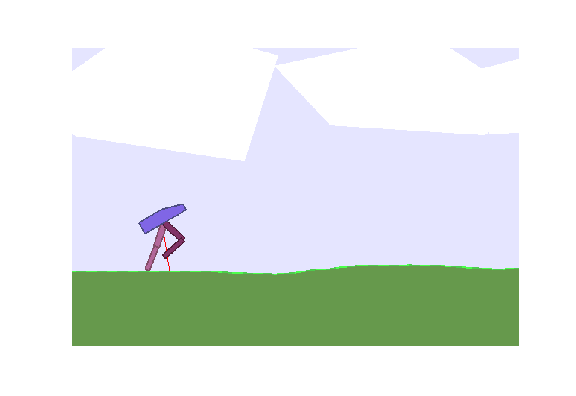
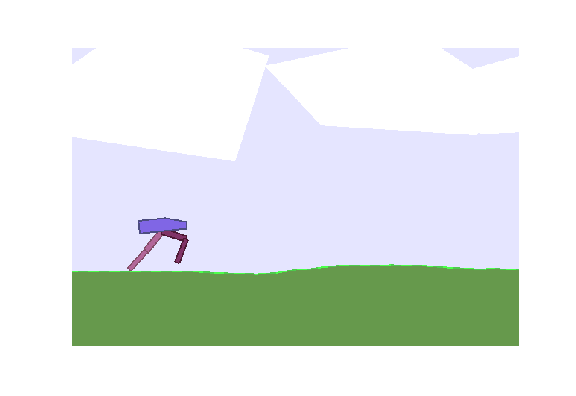
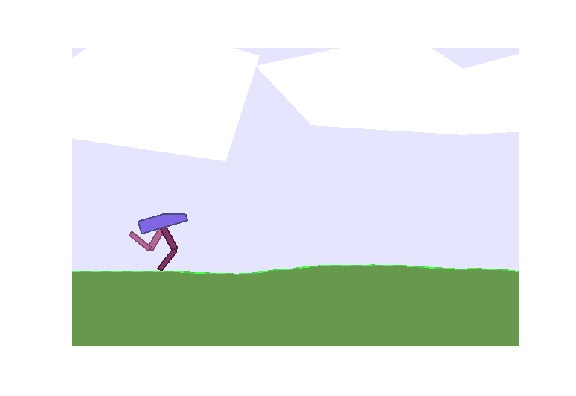
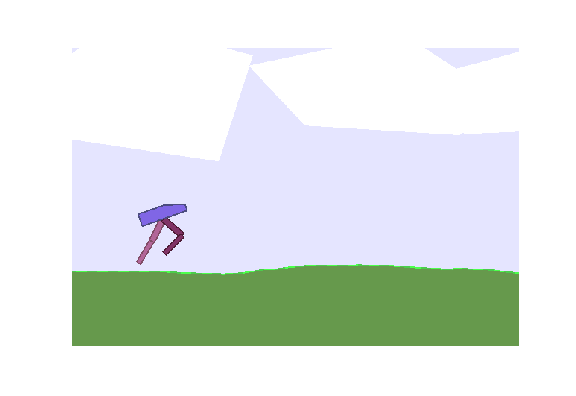
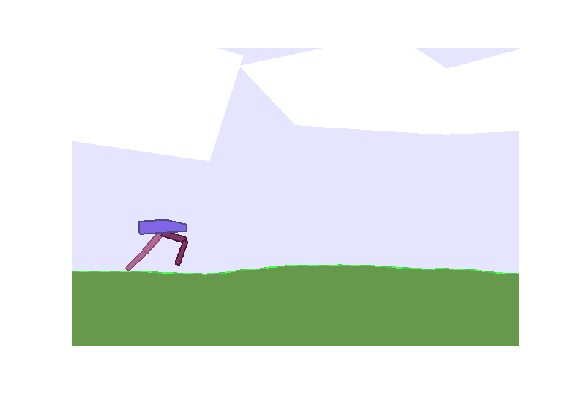
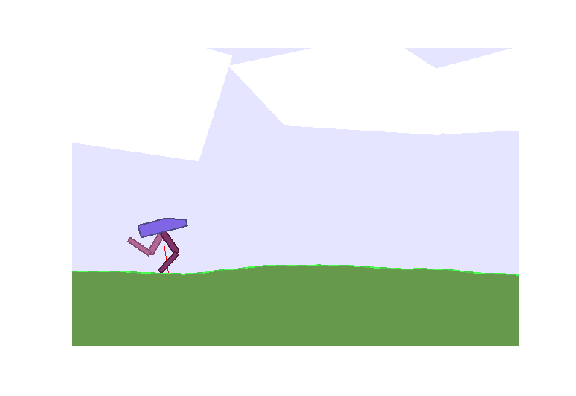
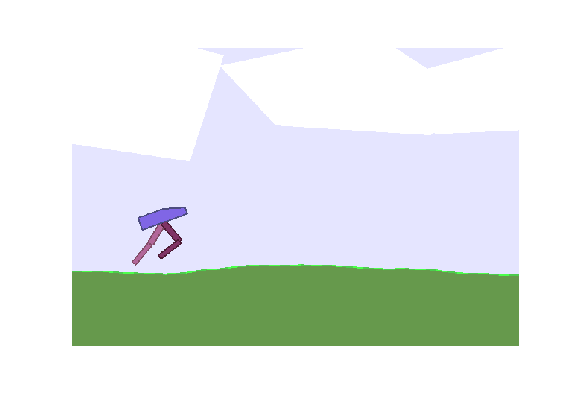
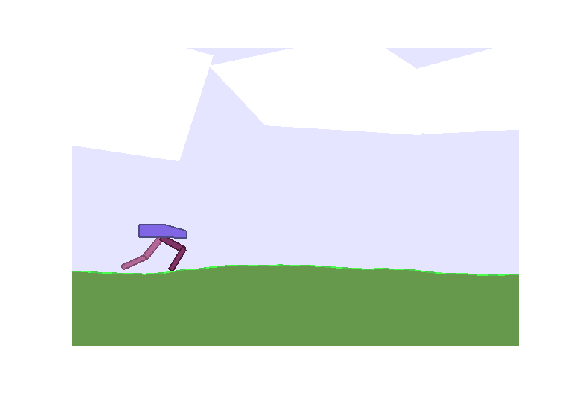
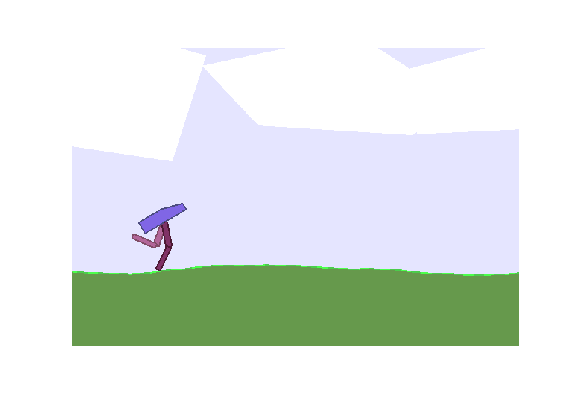
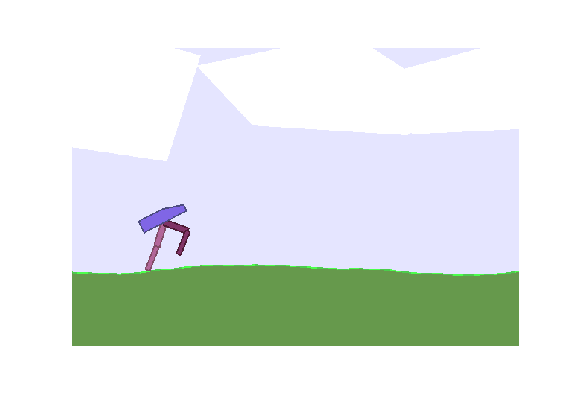
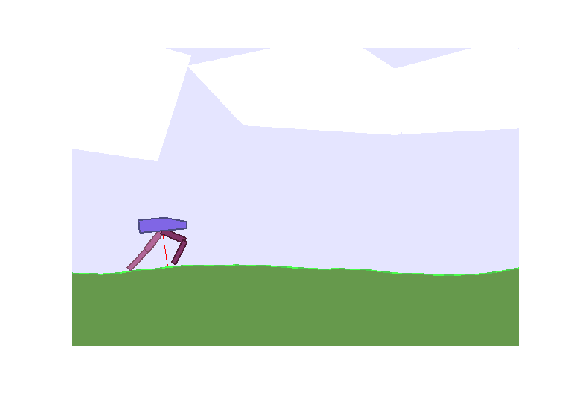
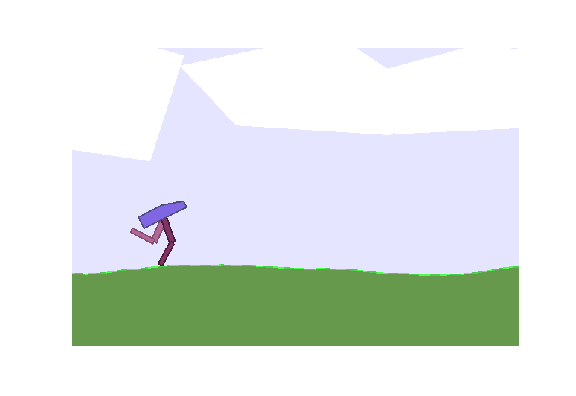
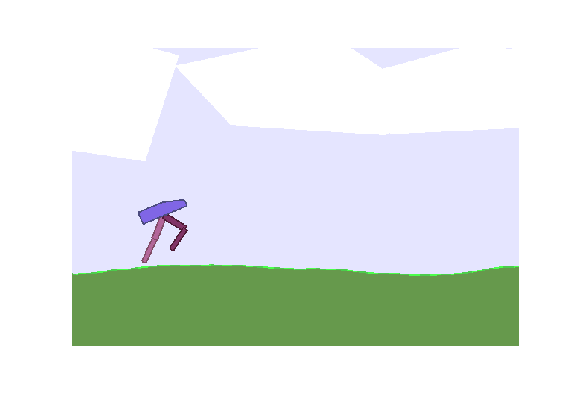
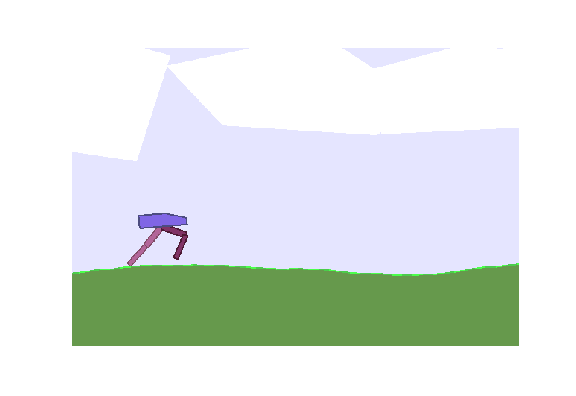
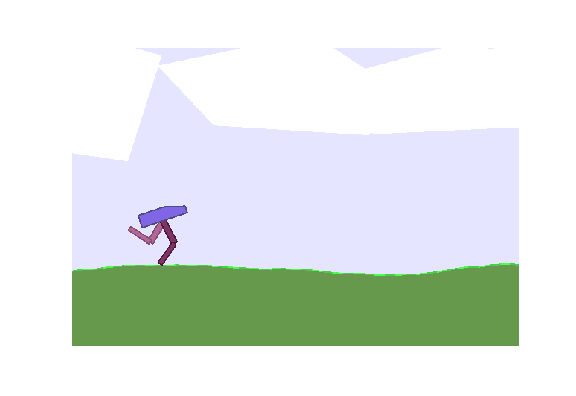
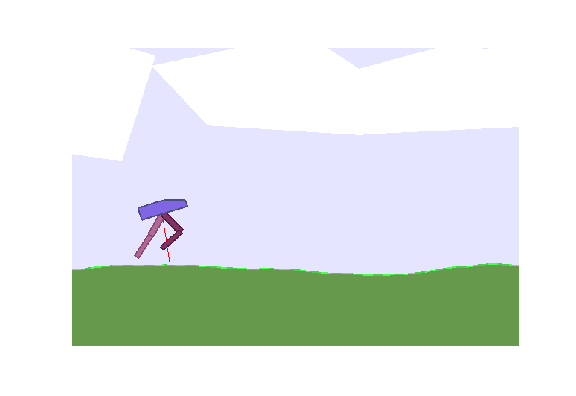
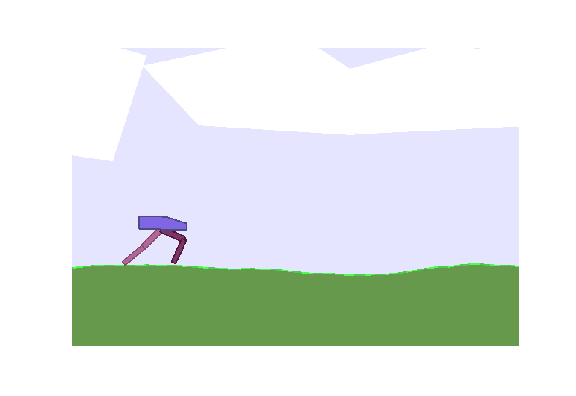
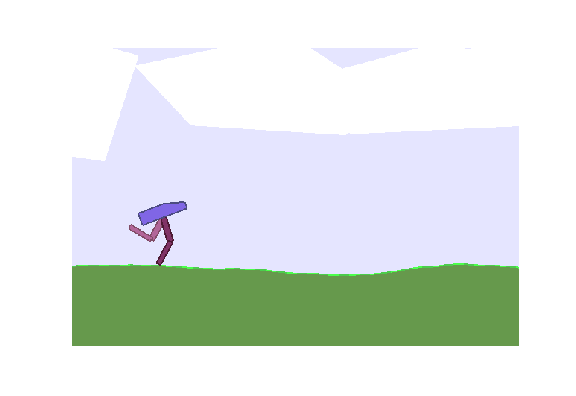
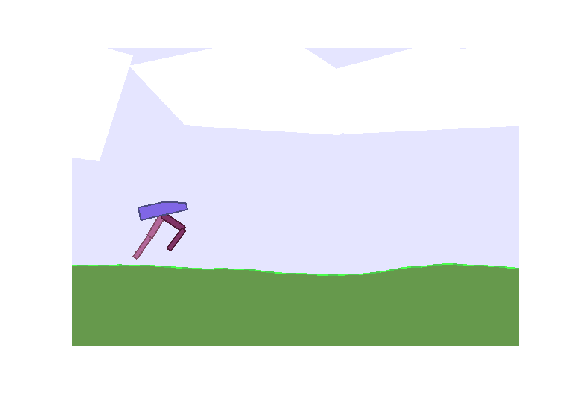
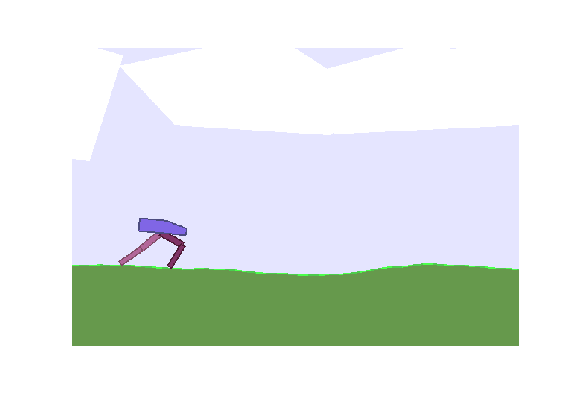
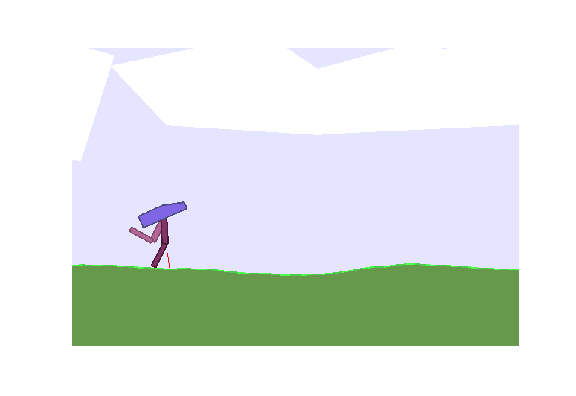
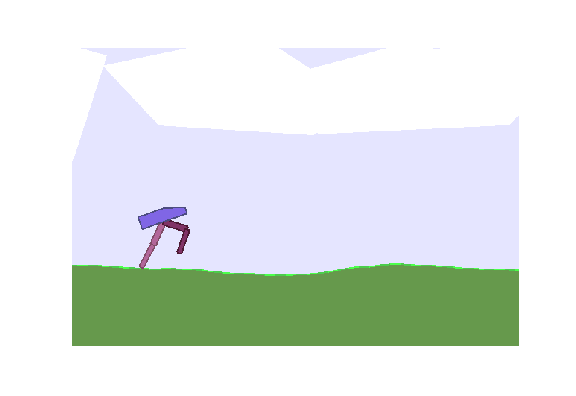
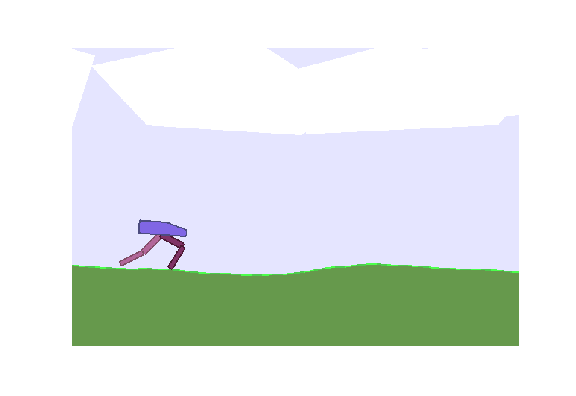
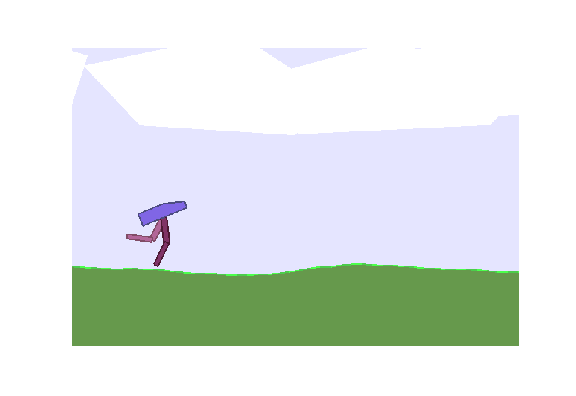
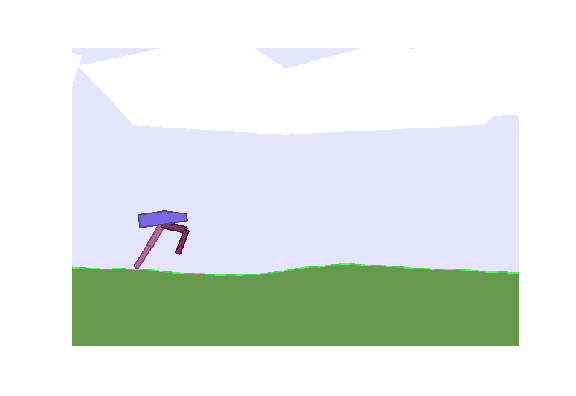
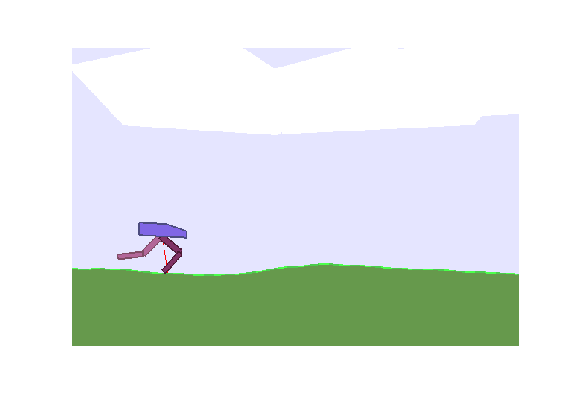
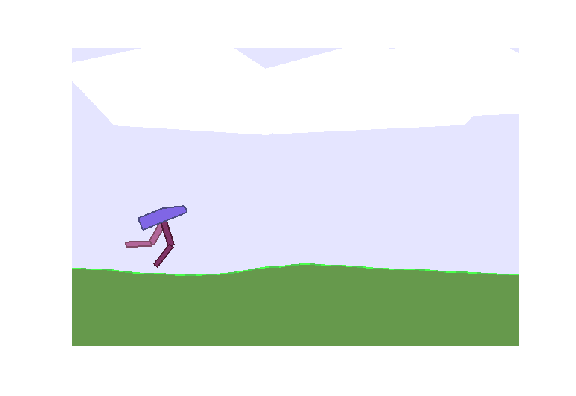
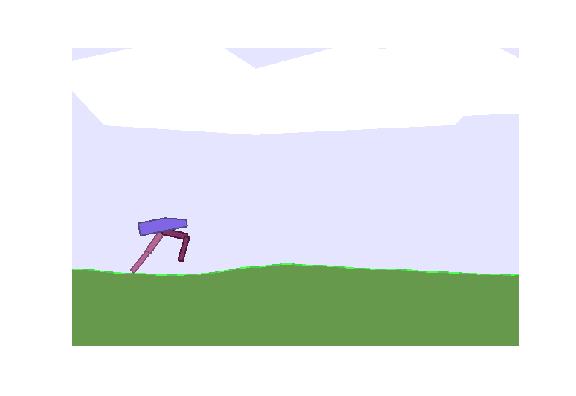
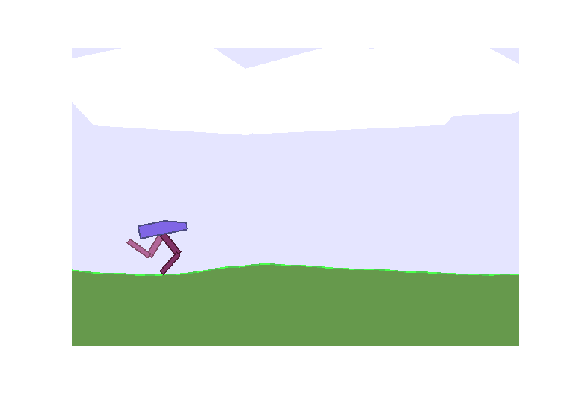
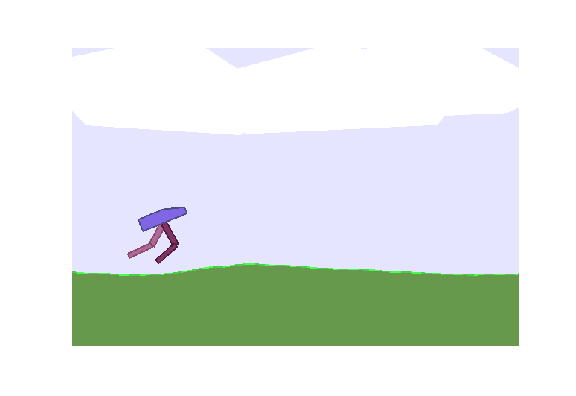
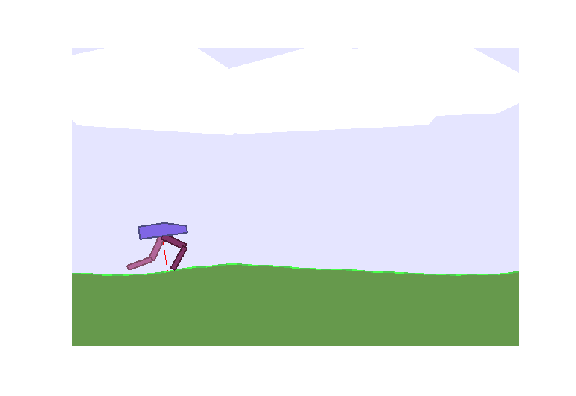
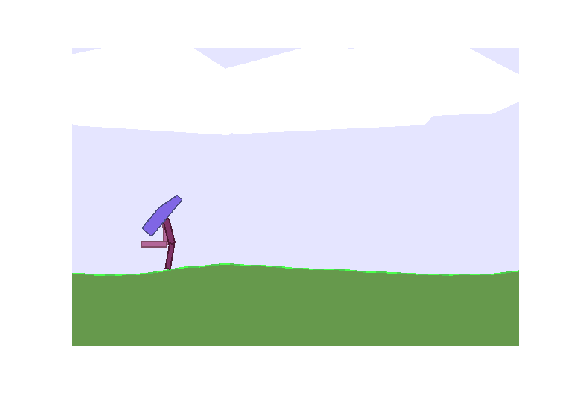
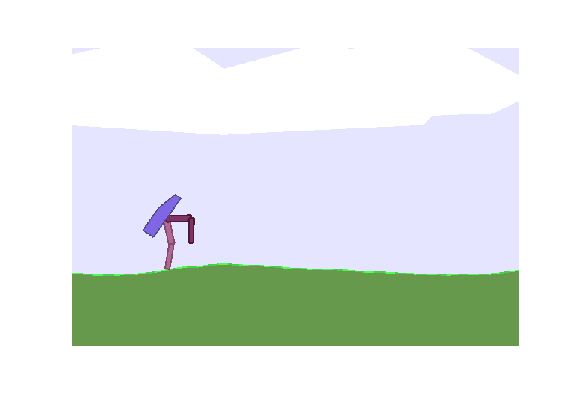
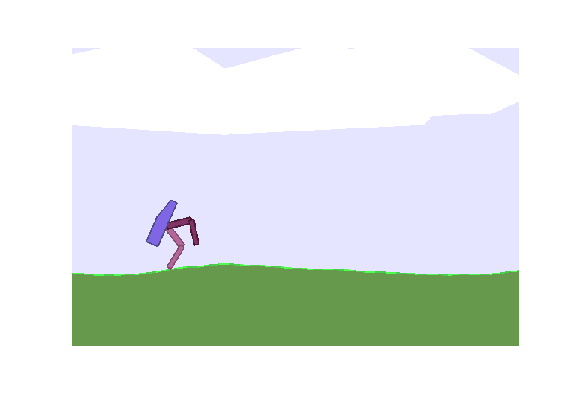
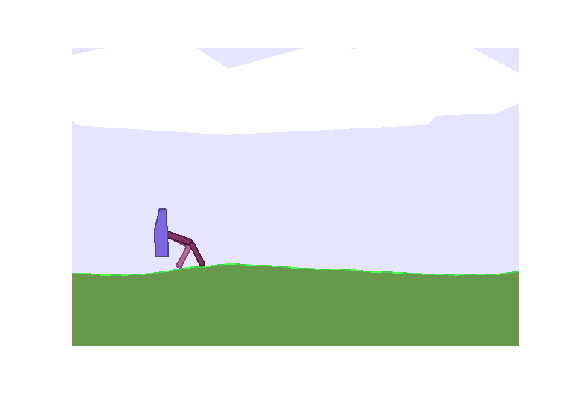

In [16]:
illustrate(norm_pol)

The performance of our agent isn't very convincing. If we train it for a few hundred more epochs though, it will learn to walk.

However, let's optimize our learning a little instead.

## Add Learning Rate Annealing

Using the same learning rate throughout training is suboptimal. We should start at a relatively high rate, and gradually decrease it. This way, we take big steps in the beginning (when we are far from the optimal parameters), and tiny steps when we are almost there.

I use (approximately) one half of a cosine curve. I start at twice the given learning rate, and decrease it to slightly above 0.

In [17]:
def lr_sched(lr, n, low = 5e-3):
    '''Gives us a learning rate schedule, starting at twice lr, ending slightly above 0 (at low),
    using cosine annealing.'''
    return low + (2*lr - low)*((1 + np.cos(np.pi * np.arange(n) / n)) / 2)

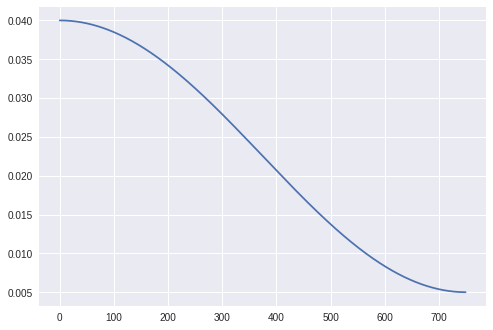

In [18]:
plt.plot(lr_sched(LR, SIM_NUM))

The plot above shows the learning rate per epoch of training.

In [19]:
class LearnerPlus(Learner):
    
    '''Learner with cosine annealing. Same API as Learner.'''
    
    def train(self, epochs, lr):
        self.create_lr_sched(lr, epochs)
        super().train(epochs, lr)
        
    def create_lr_sched(self, lr, epochs):
        '''Stores learning rate schedule.'''
        self.sched = lr_sched(lr, epochs)
        
    def getStep(self, grad, lr):
        '''Instead of multiplying with lr, we look up learning rate schedule'''
        return self.sched[self.epoch-1]*grad

In [20]:
norm_pol_anneal = norm_Policy()
learn = LearnerPlus(norm_pol_anneal)

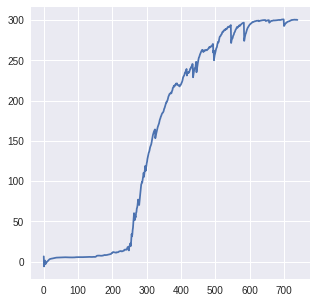

100%|██████████| 750/750 [1:55:21<00:00,  9.23s/it]


In [21]:
learn.train(SIM_NUM, LR)

Total reward: 298.8601990977844



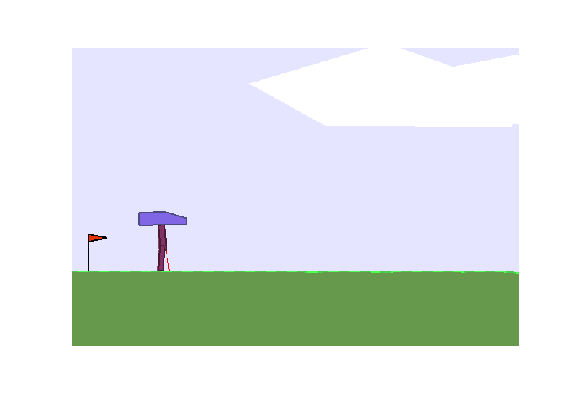
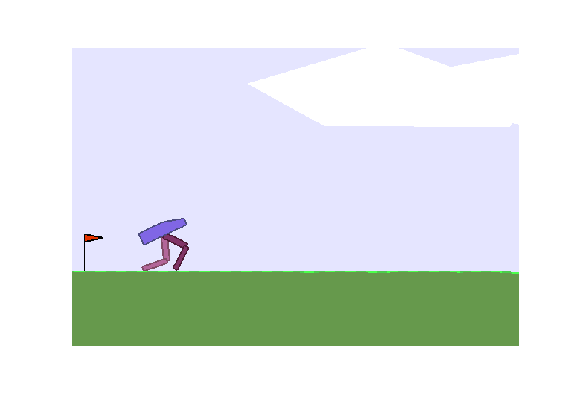
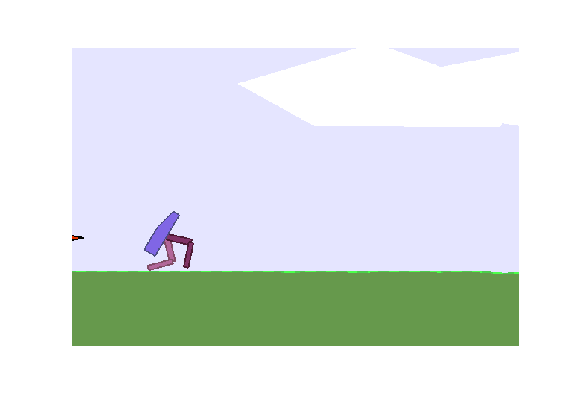
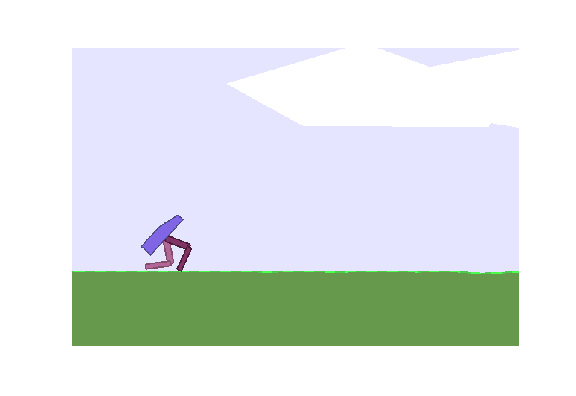
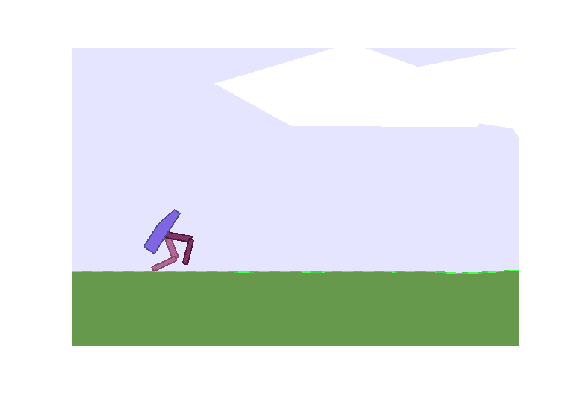
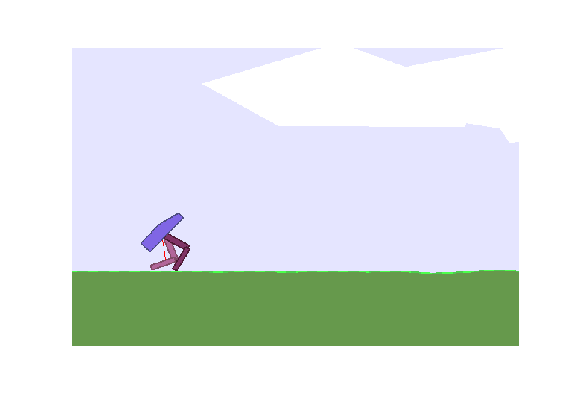
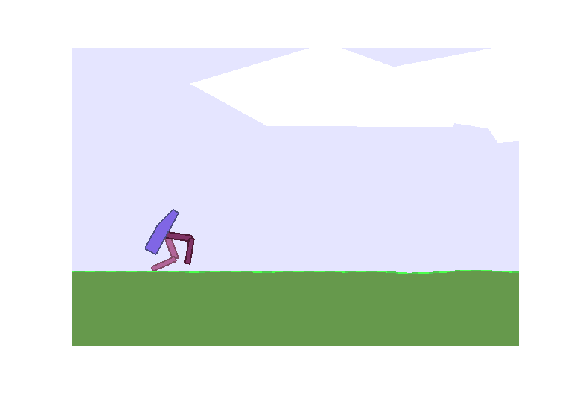
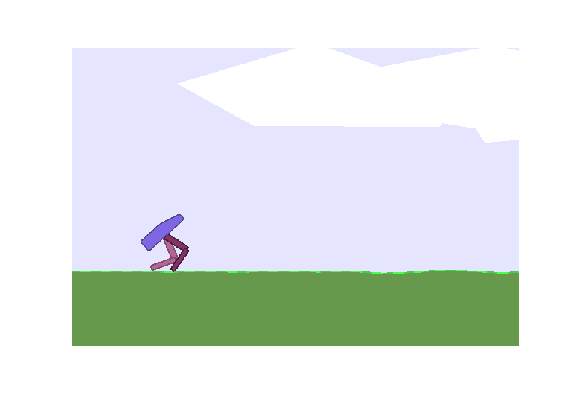
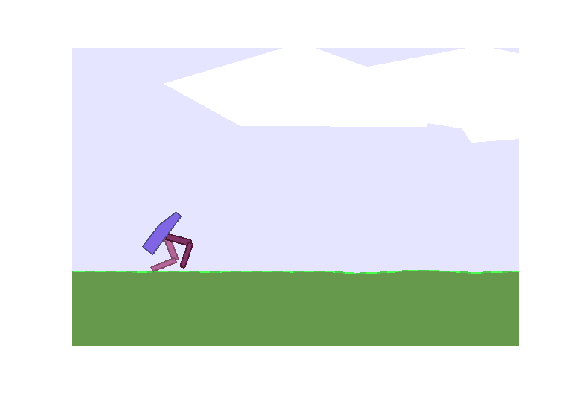
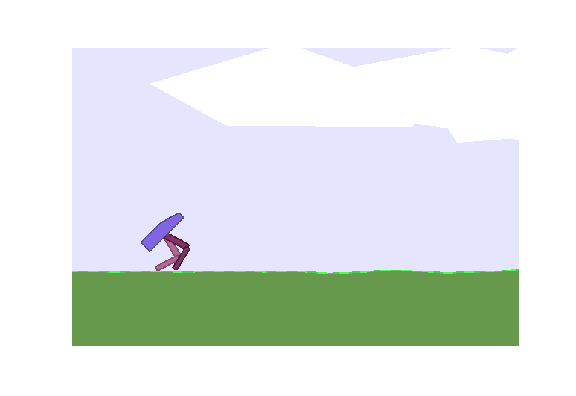
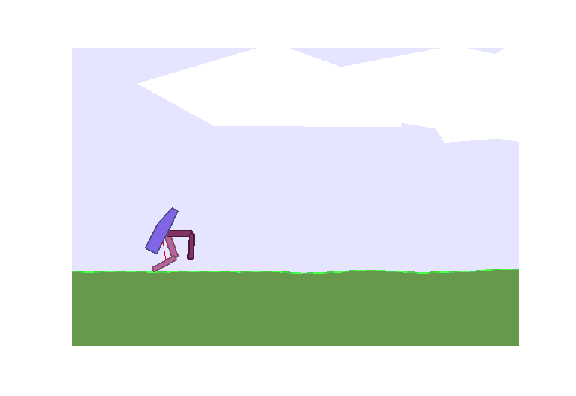
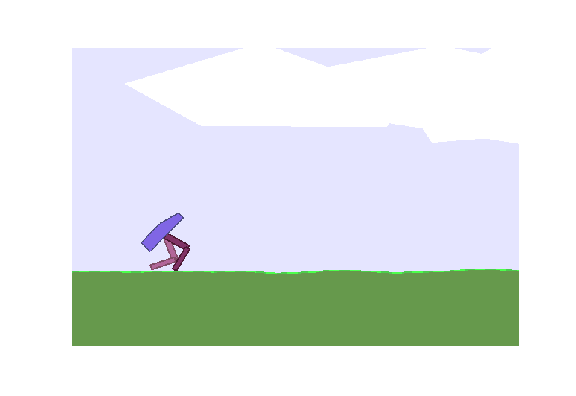
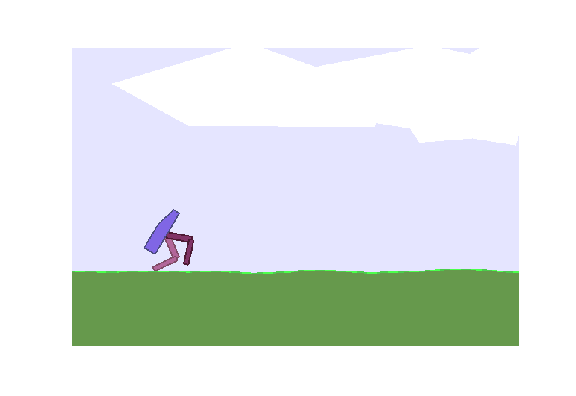
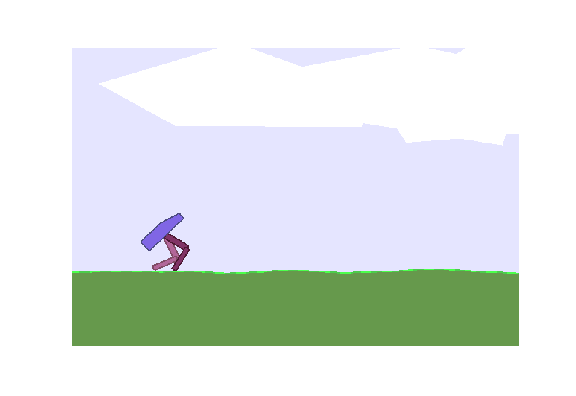
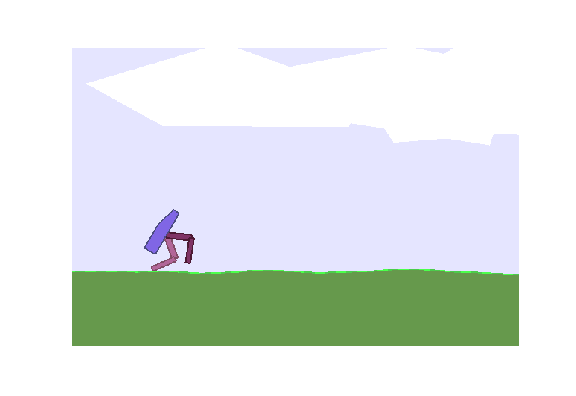
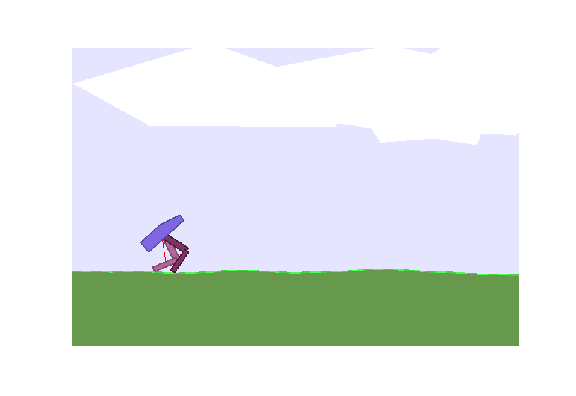
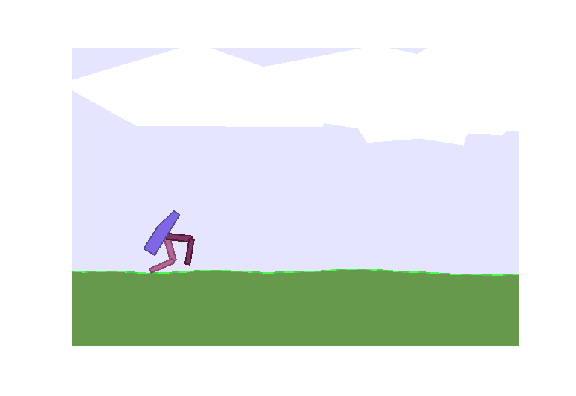
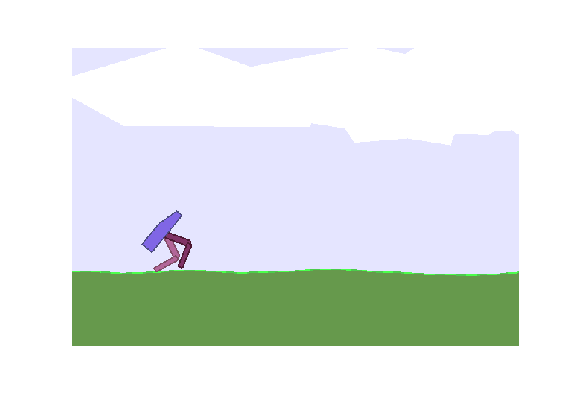
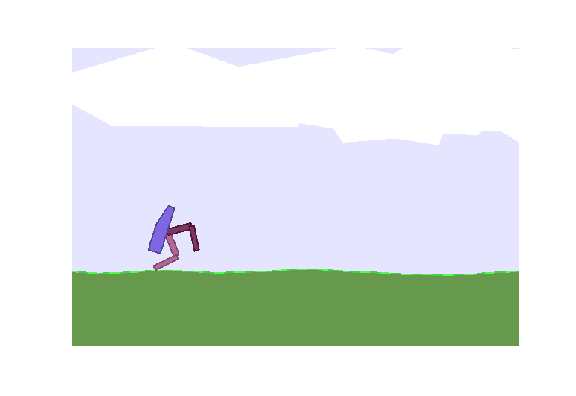
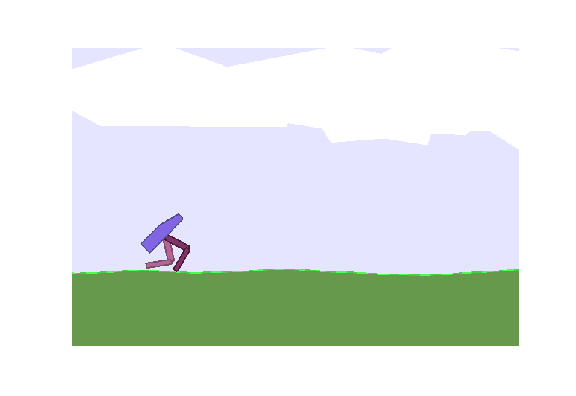
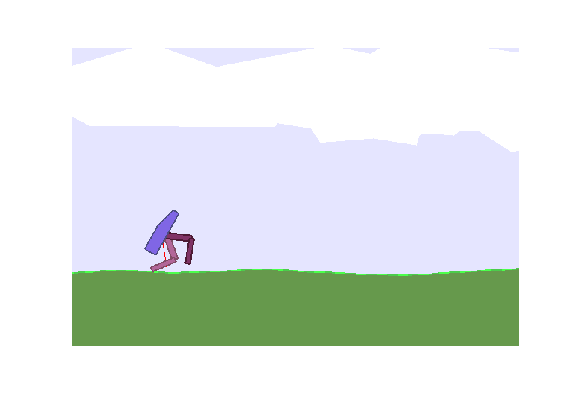
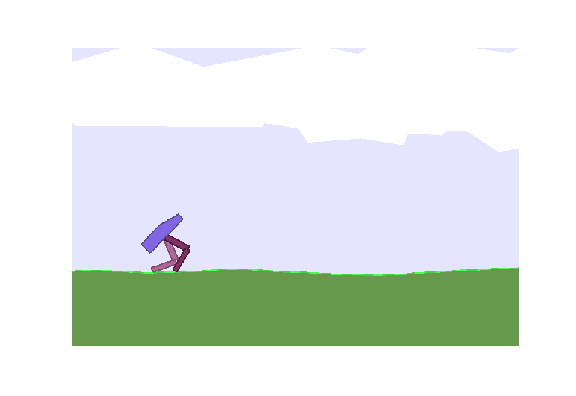
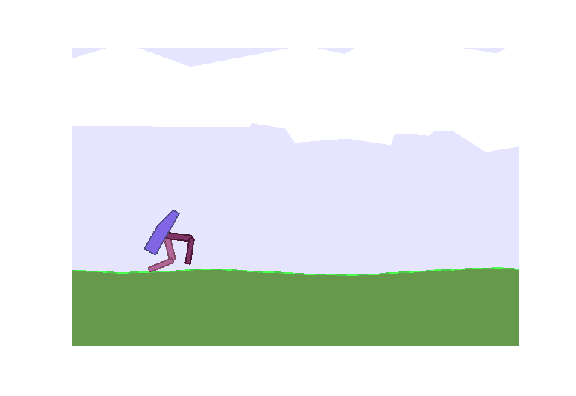
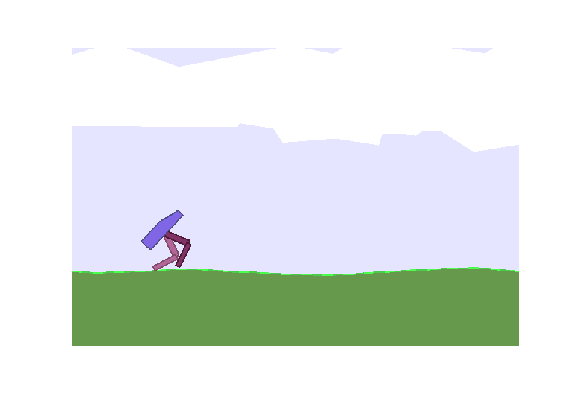
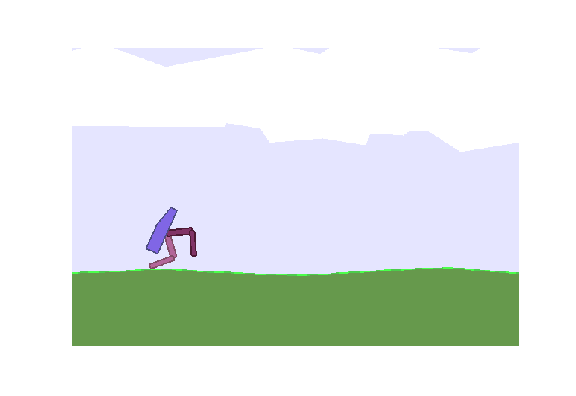
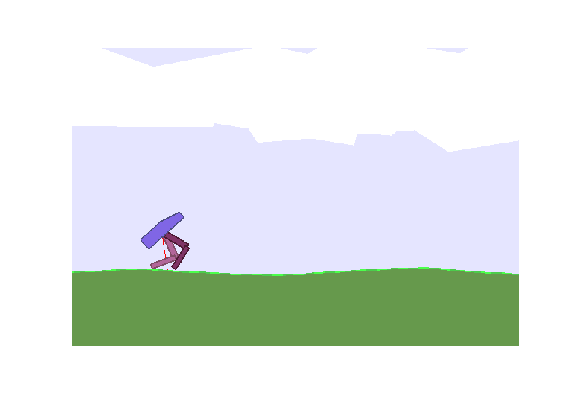
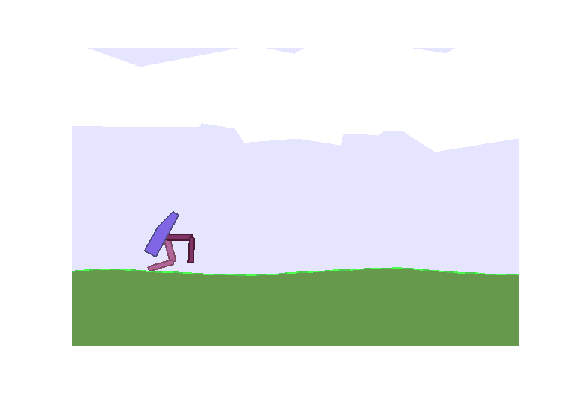
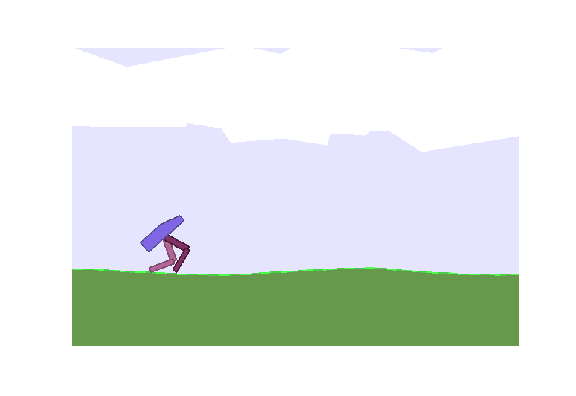
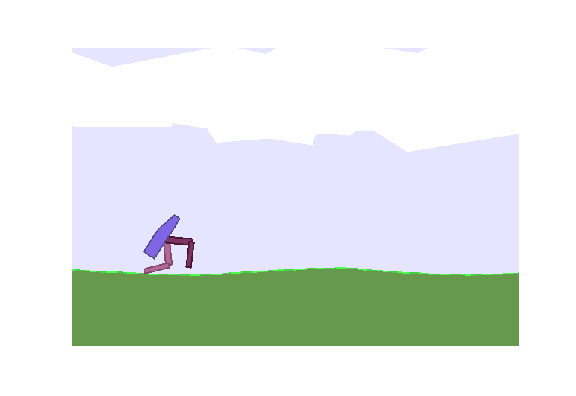
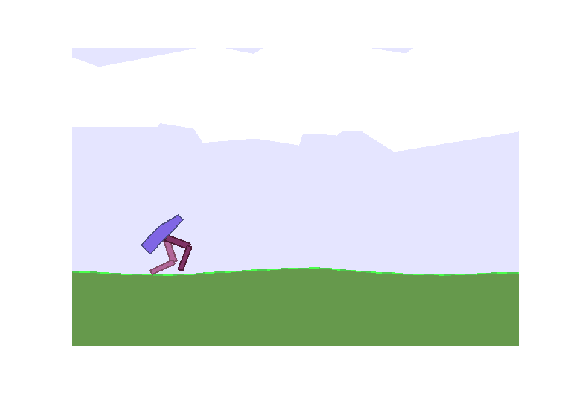
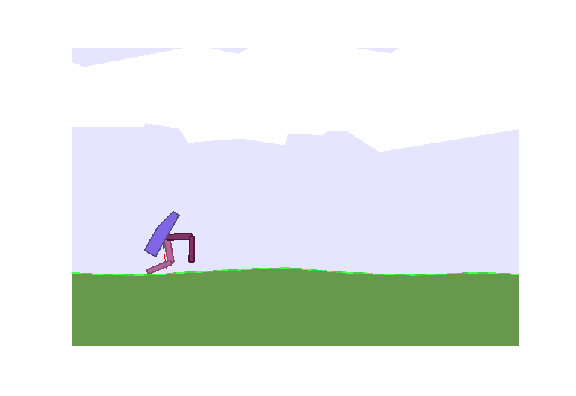
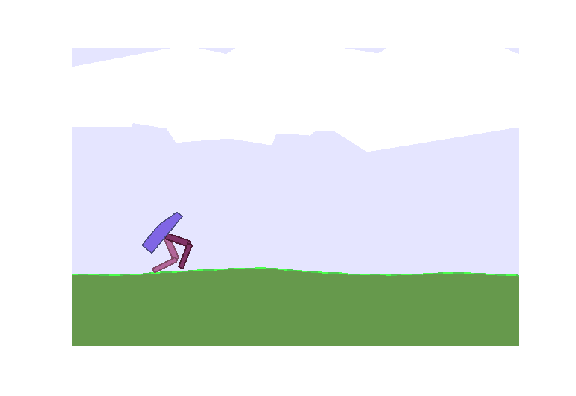
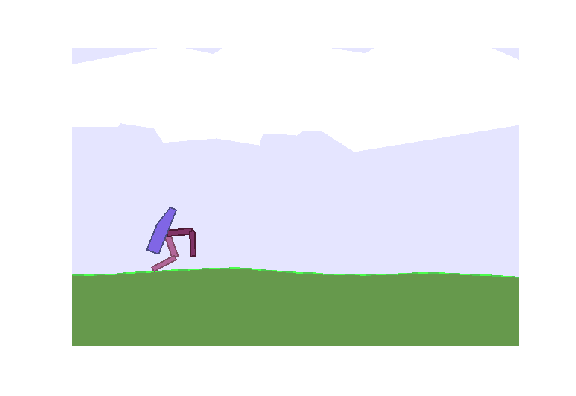
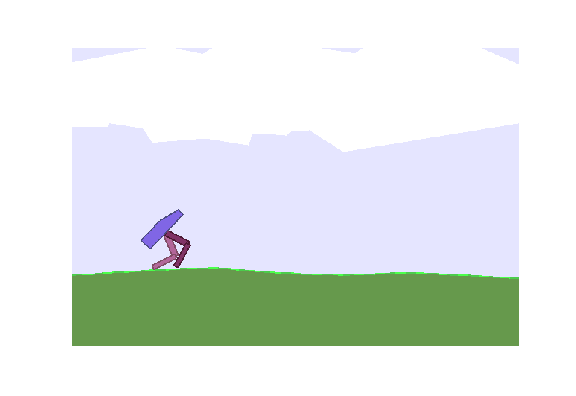
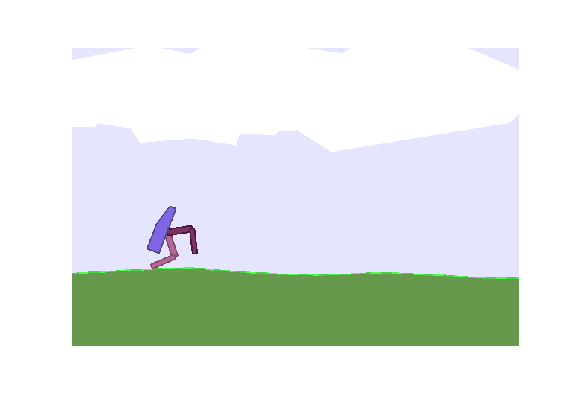
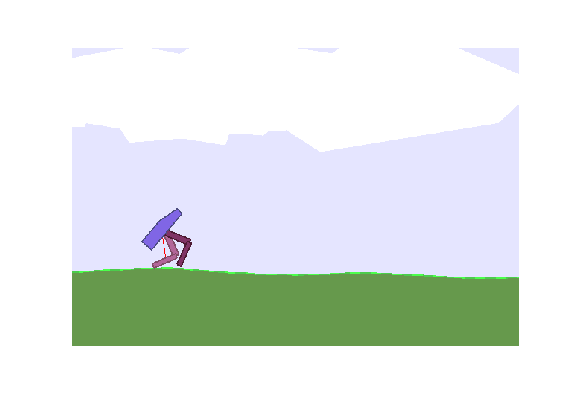
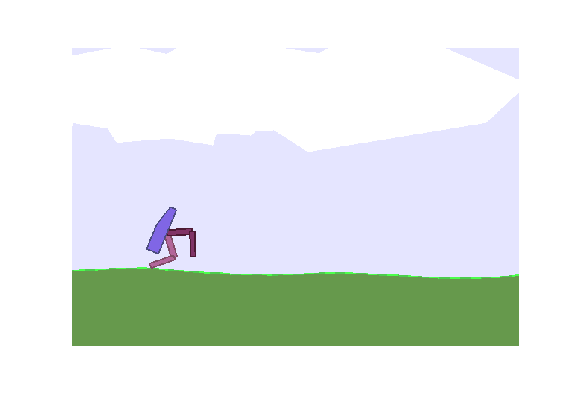
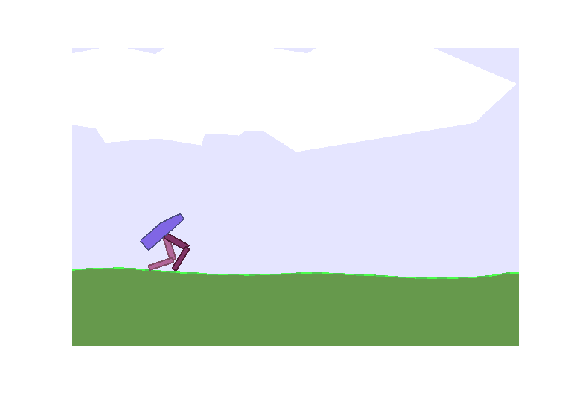
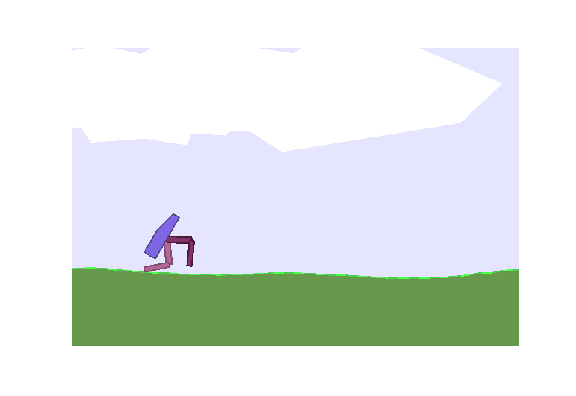
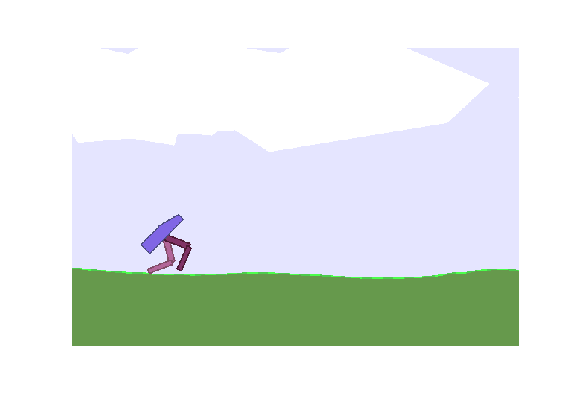
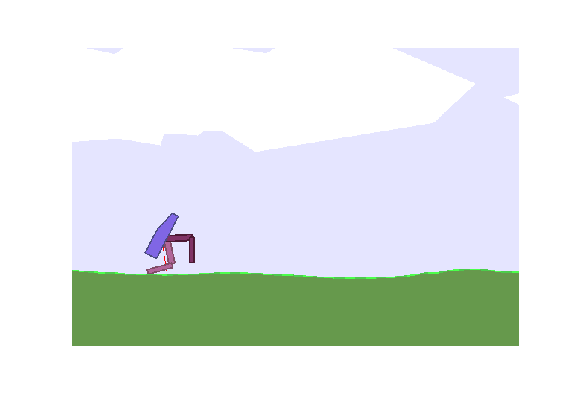
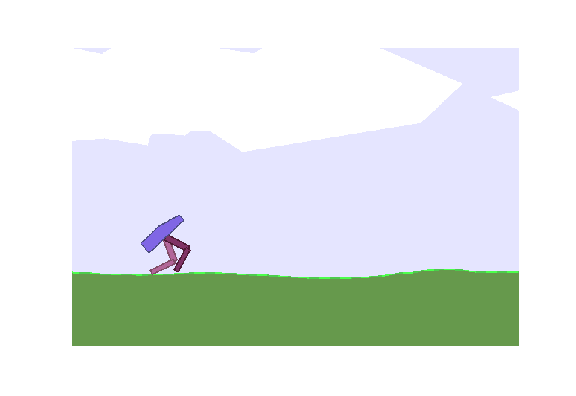
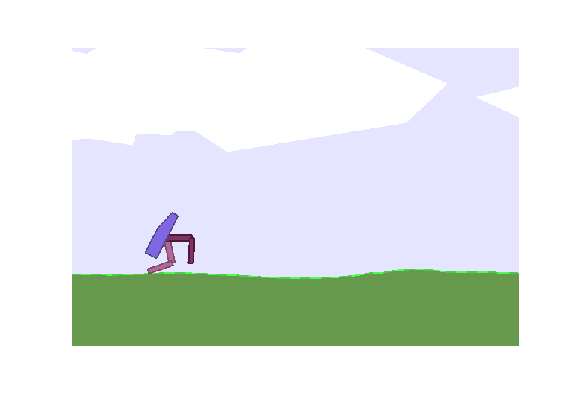
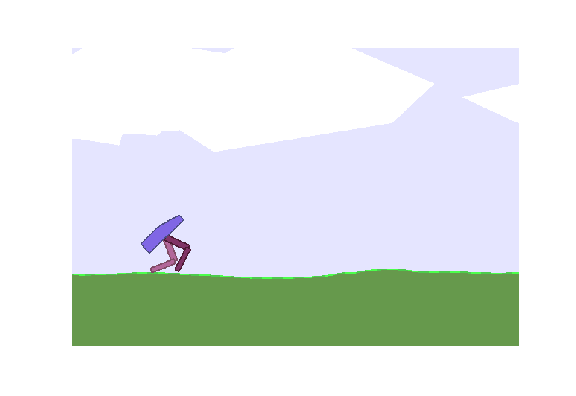
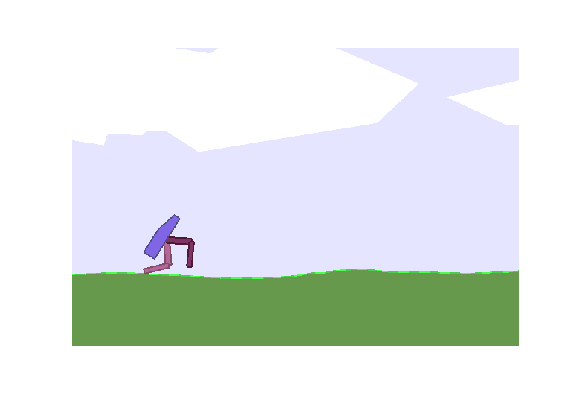
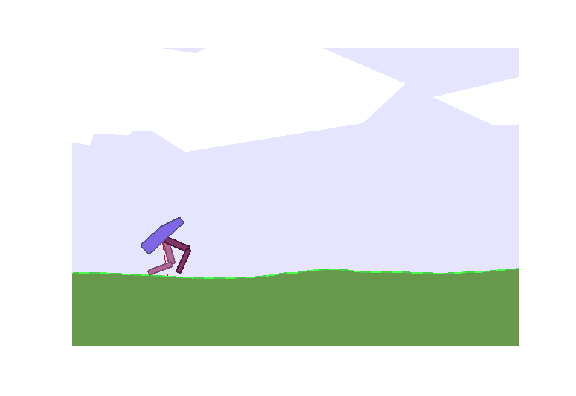
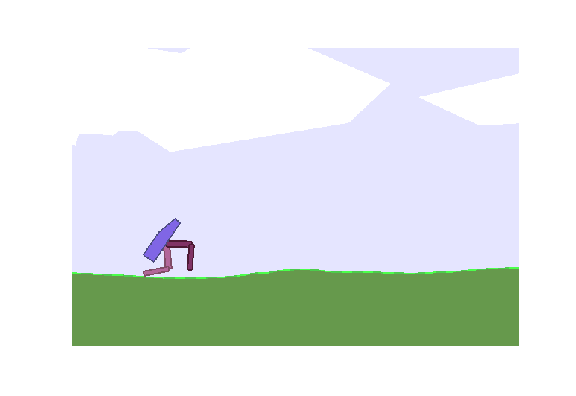
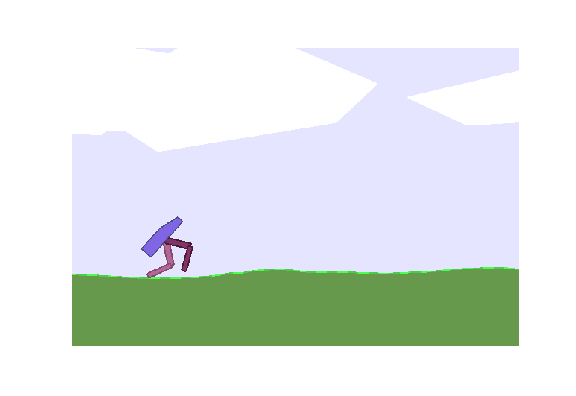
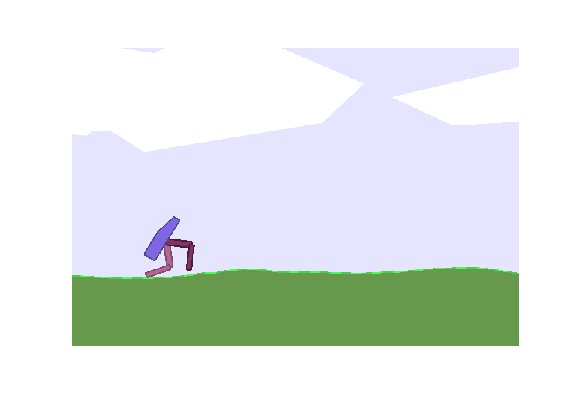
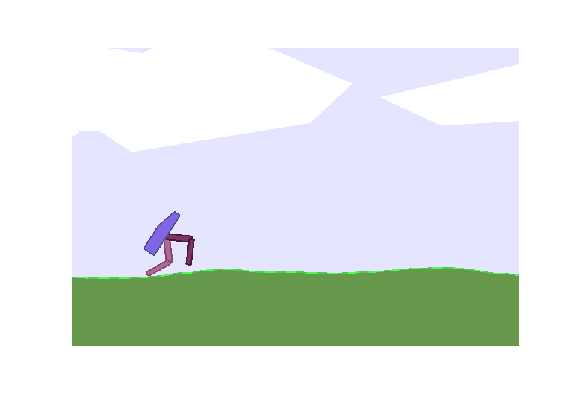
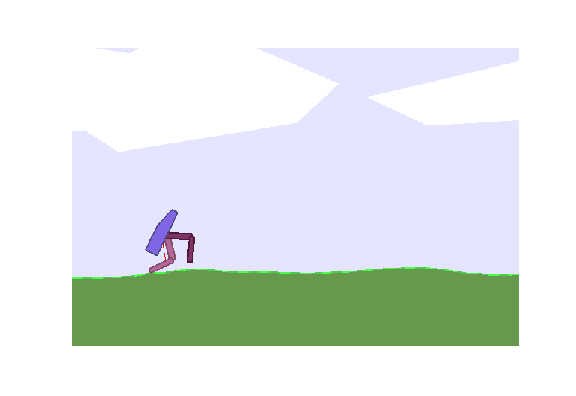
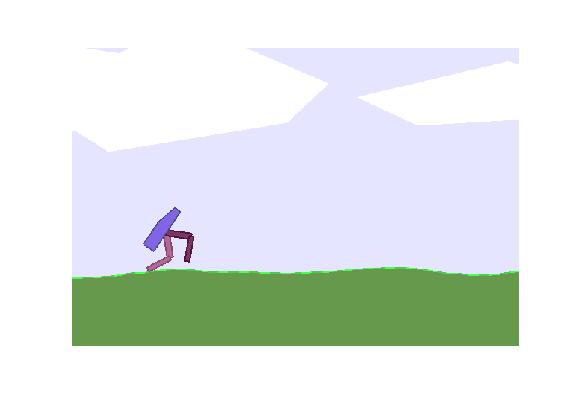
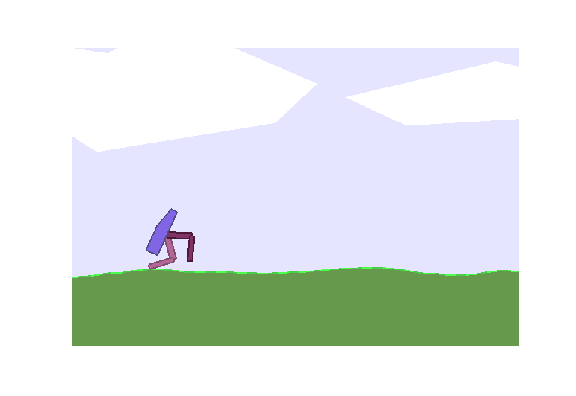
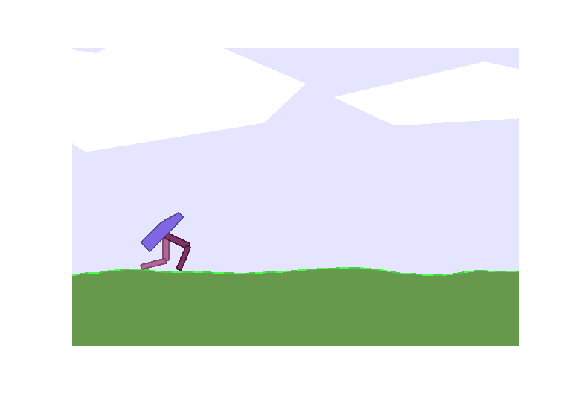
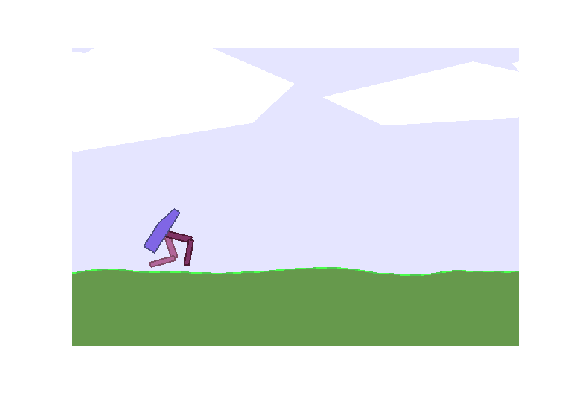
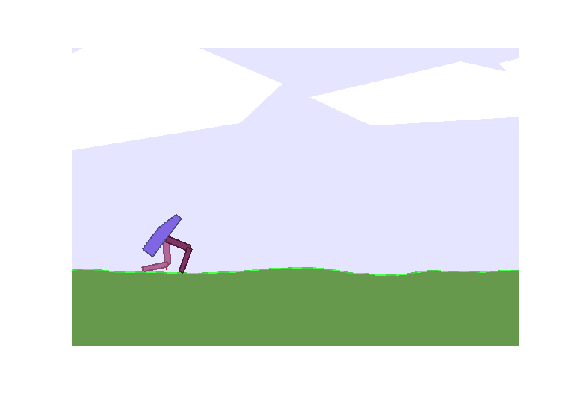
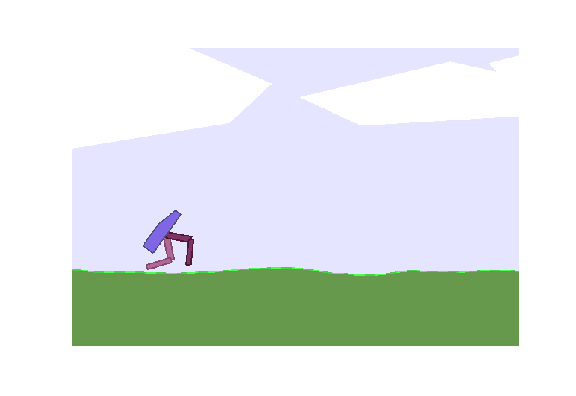
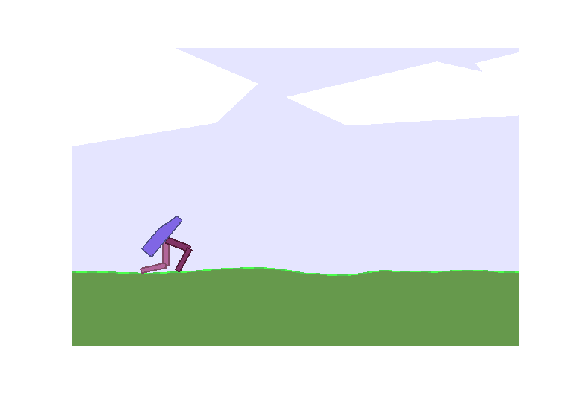
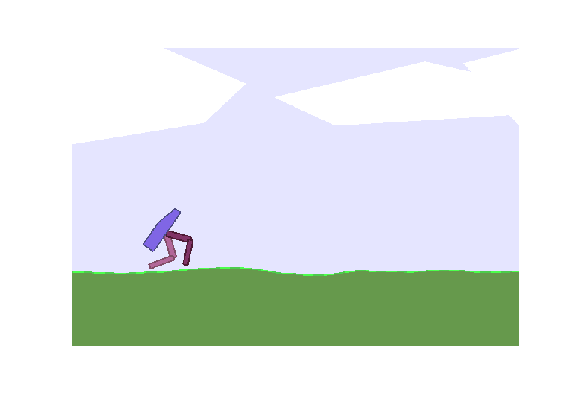
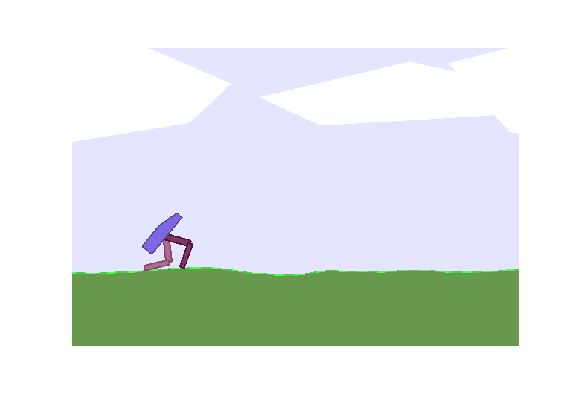
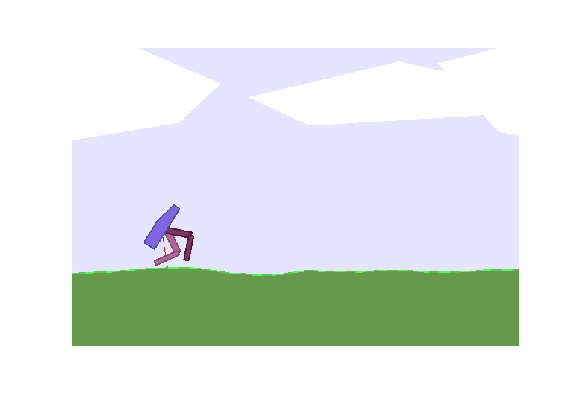
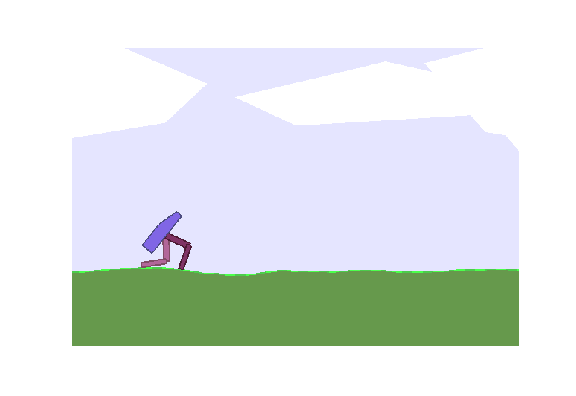
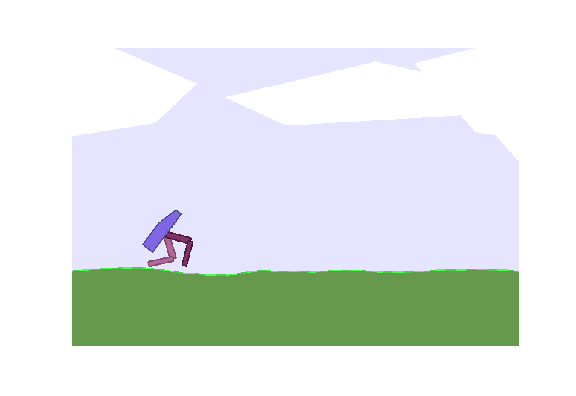
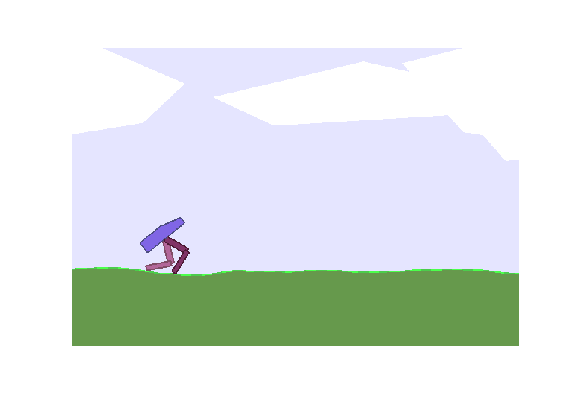
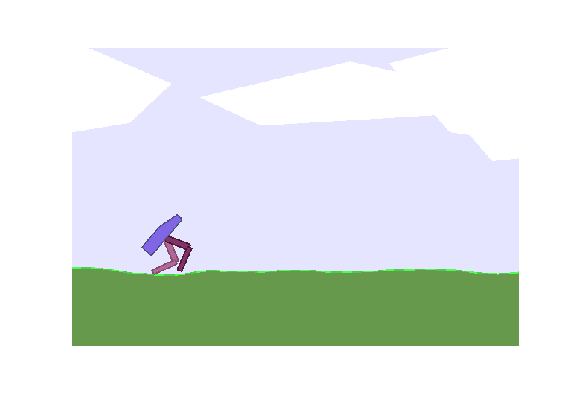
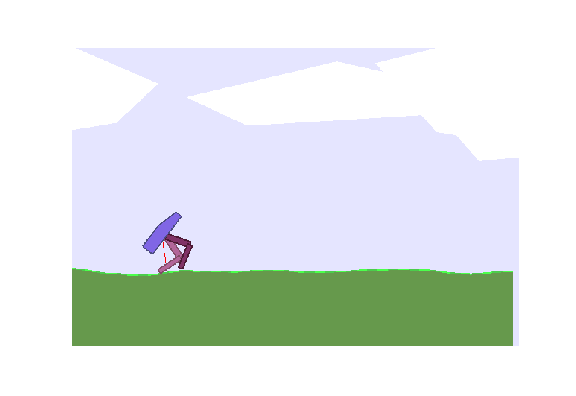
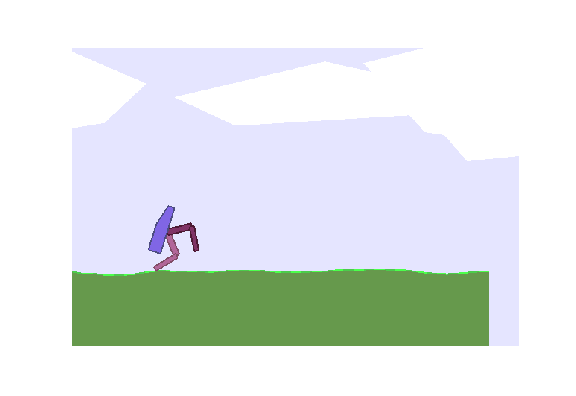
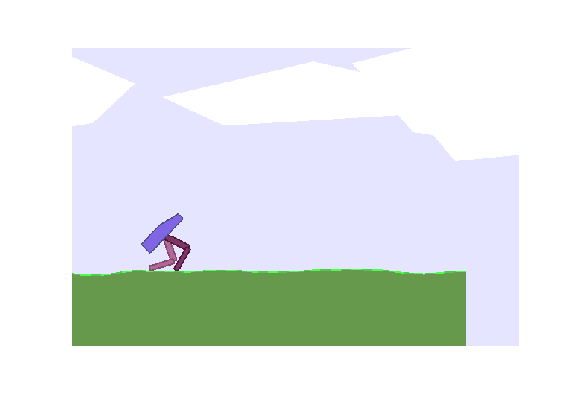
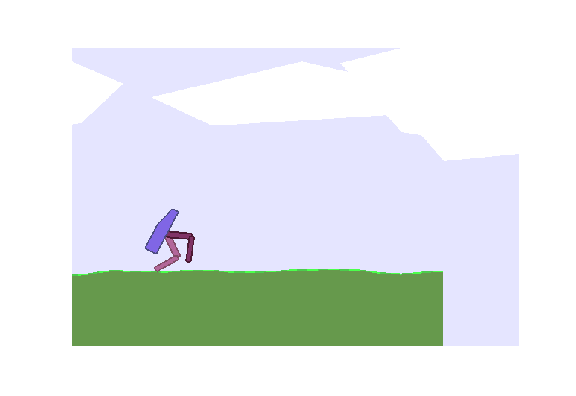
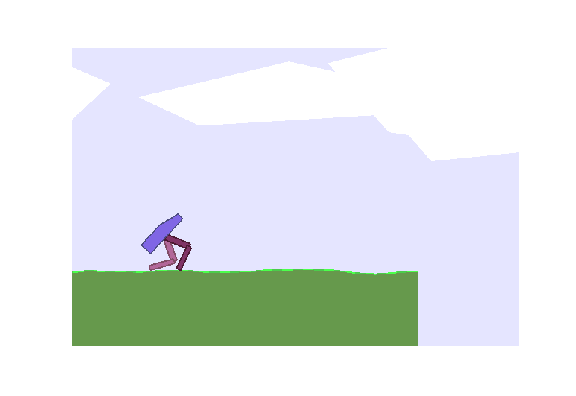
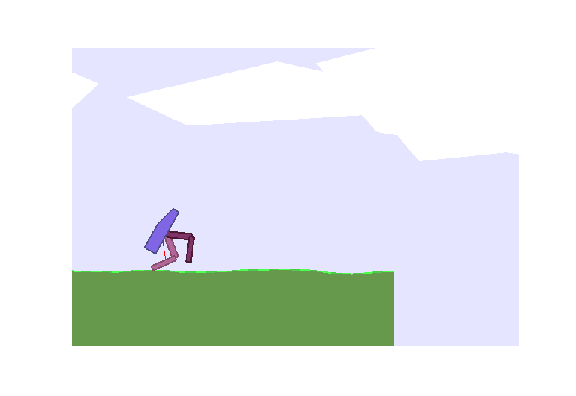
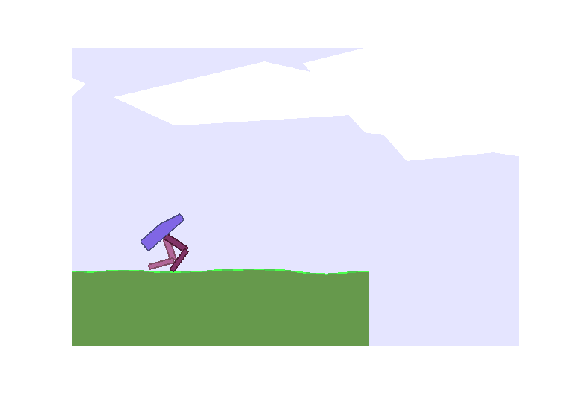
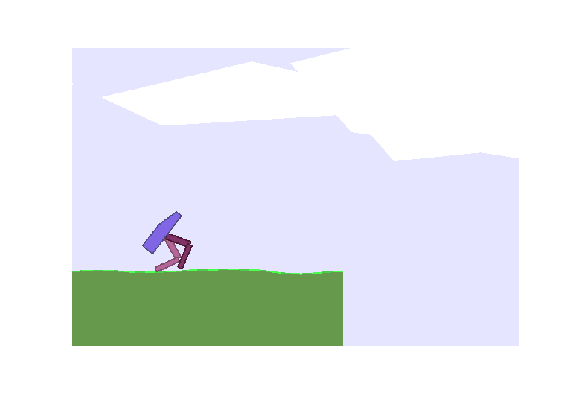
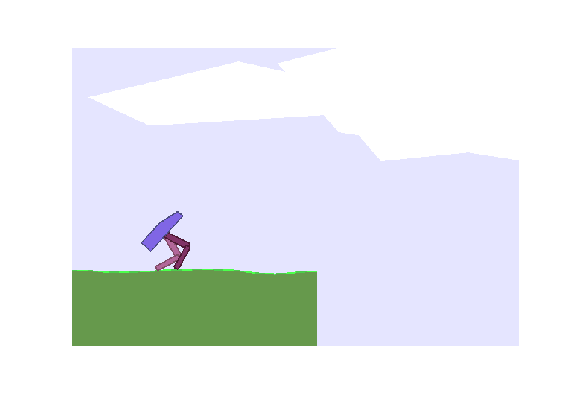
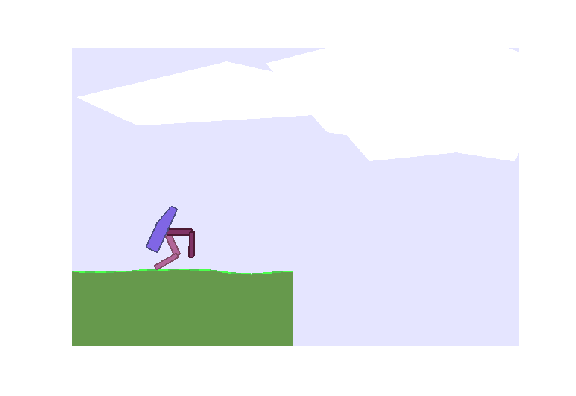
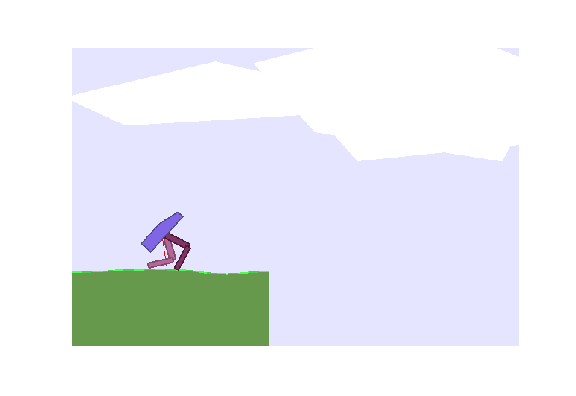

In [22]:
illustrate(norm_pol_anneal)

And voila. After training for 750 epochs, our agent is doing pretty well. In fact, 500 epochs would have been enough.